In [ ]:
!pip install emd

In [39]:
config = emd.sift.get_config('mask_sift')
config['max_imfs'] = 7
config['mask_freqs'] = 50/sample_rate
config['mask_amp_mode'] = 'ratio_sig'
config['imf_opts/sd_thresh'] = 0.05
    
from functools import partial
my_mask_sift = partial(emd.sift.mask_sift, **config)

In [40]:
def holospectrum(fam, fcarrier, sholo):
    plt.axes([.75, .1, .500, .9])
    plt.pcolormesh(fam, fcarrier, sholo, cmap='ocean_r', shading='nearest')
    plt.grid(color='grey', linestyle='-', linewidth=0.3)
    plt.yscale('log')
    plt.xscale('log')
    plt.title('Holospectrum')
    plt.xlabel('AM Frequency (Hz)')
    plt.ylabel('Frequency (Hz)')
    plt.yticks(2**np.arange(7), 2**np.arange(7))

In [41]:
def mask_sift_second_layer(IA, masks, config={}):
    imf2 = np.zeros((IA.shape[0], IA.shape[1], config['max_imfs']))
    for ii in range(IA.shape[1]):
        config['mask_freqs'] = masks[ii:]
        tmp = emd.sift.mask_sift(IA[:, ii], **config)
        imf2[:, ii, :tmp.shape[1]] = tmp
    return imf2

In [68]:
#função p calcular o hilbert huang 
def hilbert_huang(data, sample_rate=200):
     imf = my_mask_sift(data)

###2. calculando o conteudo das imfs (fase, freq e amplitude instantaneas)
     IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')
    
# Define sift parameters for the second level
     masks = np.array([25/2**ii for ii in range(12)])/sample_rate
     config = emd.sift.get_config('mask_sift')
     config['mask_amp_mode'] = 'ratio_sig'
     config['mask_amp'] = 2
     config['max_imfs'] = 5
     config['imf_opts/sd_thresh'] = 0.05
     config['envelope_opts/interp_method'] = 'mono_pchip'

# Sift the first 5 first level IMFs
     imf2 = emd.sift.mask_sift_second_layer(IA, masks, sift_args=config)

##2.2. calculando o conteudo da imf2
     IP2, IF2, IA2 = emd.spectra.frequency_transform(imf2, sample_rate, 'nht')
    
    ###3. definindo os bins de frequencia que serão usados no histograma
     carrier_hist = (1, 100, 128, 'log') # Carrier frequency histogram 
     am_hist = (1e-2, 32, 64, 'log') # AM frequency histogram

###4. 1d, 2d e 3d hilbert huang transform
#(power over carrier frequency)
     fcarrier, spec = emd.spectra.hilberthuang(IF, IA, carrier_hist, sum_imfs=False)

#power over time x carrier frequency)
     fcarrier, hht = emd.spectra.hilberthuang(IF, IA, carrier_hist, sum_time=False)
     shht = ndimage.gaussian_filter(hht, 2)

#time averaged Holospectrum (power over carrier frequency x AM frequency)
     fcarrier, fam, holo = emd.spectra.holospectrum(IF, IF2, IA2, carrier_hist, am_hist)
     sholo = ndimage.gaussian_filter(holo, 1)
        
     return fcarrier, fam, spec, sholo 

In [43]:
import matplotlib.pyplot as plt
import emd
#import mne
from scipy.io import loadmat
import numpy as np
from scipy import ndimage

path = r"C:\Users\Camila\OneDrive - Universidade Federal do Pará - UFPA\Documentos\LABNEP\EEG TESTE\DATASET\cleaned0_50Hz"
file = r"0000101_50hz.set"

matdat1 = loadmat(f'{path}\{file}')
matdat = matdat1['data'].flatten()

time = matdat1['times'].flatten()
sample_rate = 200

In [59]:
HHT = hilbert_huang(matdat, sample_rate)

In [65]:
fcarrier = HHT[0]
fam = HHT[1]
spec = HHT[2]
sholo = HHT[3]

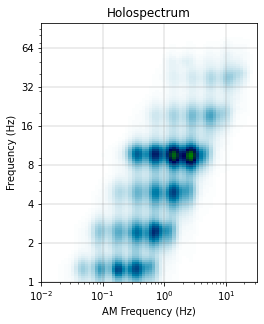

In [67]:
holospectrum(fam, fcarrier, sholo)

In [ ]:
#erro
#laço for para computar os 28 arquivos da pasta 
import os

path = r"C:\Users\Camila\OneDrive - Universidade Federal do Pará - UFPA\Documentos\LABNEP\EEG TESTE\DATASET\cleaned0_50Hz"

files_saved = []

files = os.listdir(path)

for each_file in files:
    full_path = "%s/%s" % (path, each_file)
    matdat1 = loadmat(full_path)
    data = matdat1['data'].flatten()
    
    HHT = hilbert_huang(data, sample_rate)
    holo = holospectrum(HHT[1], HHT[0], HHT[3])
    